# Imports

In [ ]:
# Imports
import pandas as pd
import numpy as np
from typing import Annotated
from scipy.stats import pearsonr
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import pearsonr
from pydantic import BaseModel, Field, HttpUrl, PositiveInt, ValidationError
import great_expectations as gx

# gx context for the data quality tests
context = gx.get_context(mode='file')


# Options
pd.set_option('display.max_columns', 100)

# Utils Functions

In [2]:
# Data Validation Model
class MoviesMetadataModel(BaseModel):

    color : str
    director_name: str
    num_critic_for_reviews: Annotated[int, Field(strict=False, ge=0)]
    duration: Annotated[float, Field(strict=False, ge=0)]
    director_facebook_likes: Annotated[int, Field(strict=False, ge=0)]
    actor_3_facebook_likes: Annotated[int, Field(strict=False, ge=0)]
    actor_2_name: str
    actor_1_facebook_likes: Annotated[int, Field(strict=False, ge=0)]
    gross: Annotated[float, Field(strict=False, ge=0)]
    genres: str
    actor_1_name: str
    movie_title: str
    num_voted_users: Annotated[int, Field(strict=False, ge=0)]
    cast_total_facebook_likes: Annotated[int, Field(strict=False, ge=0)]
    actor_3_name: str
    facenumber_in_poster: Annotated[int, Field(strict=False, ge=0)]
    plot_keywords: str
    movie_imdb_link: HttpUrl
    num_user_for_reviews: PositiveInt
    language: str
    country:str
    content_rating: str
    budget: Annotated[float, Field(strict=False, ge=0)]
    title_year: PositiveInt
    actor_2_facebook_likes: int
    imdb_score: Annotated[float, Field(strict=False, ge=0)]
    aspect_ratio: Annotated[float, Field(strict=False, ge=0)]
    movie_facebook_likes: Annotated[int, Field(strict=False, ge=0)]


In [ ]:
def percentage_missing(data):
    """
    Calculate the percentage of missing values for each column in a DataFrame.

    Parameters:
        data (pd.DataFrame): The input pandas DataFrame to analyze.

    Returns:
        pd.Series: A Series where each element represents the percentage of 
                   missing values for the corresponding column in the DataFrame.
    """
    
    missing = data.isna().sum()
    total = data.shape[0]
    percentage = 100*(missing/total)
    
    return percentage

def del_spaces(data:pd.DataFrame)->pd.DataFrame:

    """
    Remove leading and trailing whitespace from all string values in a DataFrame.

    Parameters:
        data (pd.DataFrame): The input DataFrame containing string and non-string values.

    Returns:
        pd.DataFrame: A new DataFrame with whitespace stripped from all string entries.
    """

    if isinstance(data, str):
        return data.strip()
    return data

def del_duplicates(data:pd.DataFrame)->pd.DataFrame:

    """
    Remove duplicate rows from a DataFrame.

    Parameters:
        data (pd.DataFrame): The input DataFrame from which duplicate rows should be removed.

    Returns:
        pd.DataFrame: A new DataFrame with duplicate rows removed.
    """
    data=data.drop_duplicates()

    return data

def fill_missing_zero(data:pd.DataFrame, columns_to_fill:list)->pd.DataFrame:

    """
    Fill missing values in specified columns with zero and apply logic-based imputation for the 'color' column.

    Parameters:
        data (pd.DataFrame): The input DataFrame containing missing values.
        columns_to_fill (list): A list of column names where missing values should be filled with 0.

    Returns:
        pd.DataFrame: The updated DataFrame with specified columns filled with 0, and the 'color' column 
                      filled with 'Color' where 'title_year' is greater than or equal to 1970.
    
    """
    # Filling NA
    data[columns_to_fill]=data[columns_to_fill].fillna(0)

    # Filling Color
    data.loc[(data['color'].isna())&(data['title_year']>=1970), 'color'] = 'Color'

    return data

def drop_nulls(data:pd.DataFrame)->pd.DataFrame:

    """
    Drop all rows from the DataFrame that contain any missing (NaN) values.

    Parameters:
        data (pd.DataFrame): The input DataFrame from which rows with missing values should be removed.

    Returns:
        pd.DataFrame: A new DataFrame with all rows containing NaN values dropped.
    """
    data=data.dropna()
    return data

# 1. Data Loading

What I like to do is start with the simplest solution to the problem (in this case, loading the data), and then, as needed, move on to more complex approaches. With that in mind, since a .csv file was provided, I would begin by trying a straightforward pd.read_csv(). The file wasn’t too large, so I could visually inspect it beforehand and confirm that a comma was used as the delimiter and the first row was the header—hence the use of sep=',' and header=0.

In this instance, the pd.read_csv method worked, but what could have gone wrong? If the file had been too large, I would have considered other options like Dask, Polars, or PySpark.

After the initial inspection performed in section 1.1, we identified that our dataset contains both numerical and categorical variables, and that applying some schema enforcement would be beneficial. We also discovered the presence of outliers and missing values. We will handle the missing values, but the outliers will be addressed by the data science team based on the specific business problem they are tackling.

In [95]:
# Loading data.
data = pd.read_csv('data/external/movie_metadata.csv', sep=',', header=0, skipinitialspace=True)
data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


### 1.1 Initial Inspection



For the initial inspection, besides looking at the head of the DataFrame, I would perform the actions below to get a better sense of the data:

**1. Inspect the shape.**

Just to understand the number of rows and columns (dimensionality) we’re working with.

**2. Inspect the data types.**

By checking the data types, we can determine whether some schema enforcement is needed. This is usually a good practice, so we’ll include schema validation in the pipeline.

**3. Check statistical values.**

Here we detected outliers by comparing the 75th percentile with the max value of some columns. Since the difference was large, we could infer the presence of outliers, for example, in the director_facebook_likes column.

**4. Check for unique values.**

The goal here is to get a sense of the spread or capillarity of the variables. Everything seemed normal in this regard.

**5. Check for missing values.**

By analyzing the percentage of missing data, we can understand how complete our dataset is. The variables gross and budget had the highest percentages of missing values. Since these are financial fields, we could consider filling them with zero and maybe drop the remaining missing entries after discussions with the data science and business teams.

**6. Check for duplicates.**

We found just 45 duplicate rows we can just drop them.

**7. Low variance and constant columns.**

We didn’t find any columns with low variance or constant values. This check is important because such columns contribute little to no information to the models while still incurring storage and processing costs.

In [5]:
# Inspect the shape of dataframe.
# 5043 rows and 28 columns
data.shape

(5043, 28)

In [6]:
# Inspect the data types of the columns and the size of dataframe.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [7]:
# check statistical values for the data
data.describe(include='all')

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,5024,4939,4993.000000,5028.000000,4939.000000,5020.000000,5030,5036.000000,4.159000e+03,5043,5036,5043,5.043000e+03,5043.000000,5020,5030.000000,4890,5043,5022.000000,5029,5038,4740,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
unique,2,2398,NaN,NaN,NaN,NaN,3032,NaN,NaN,914,2097,4917,NaN,NaN,3521,NaN,4760,4919,NaN,46,65,18,NaN,NaN,NaN,NaN,NaN,NaN
top,Color,Steven Spielberg,NaN,NaN,NaN,NaN,Morgan Freeman,NaN,NaN,Drama,Robert De Niro,King Kong,NaN,NaN,Steve Coogan,NaN,based on novel,http://www.imdb.com/title/tt0232500/?ref_=fn_t...,NaN,English,USA,R,NaN,NaN,NaN,NaN,NaN,NaN
freq,4815,26,NaN,NaN,NaN,NaN,20,NaN,NaN,236,49,3,NaN,NaN,8,NaN,4,3,NaN,4704,3807,2118,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,140.194272,107.201074,686.509212,645.009761,NaN,6560.047061,4.846841e+07,NaN,NaN,NaN,8.366816e+04,9699.063851,NaN,1.371173,NaN,NaN,272.770808,NaN,NaN,NaN,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,NaN,NaN,121.601675,25.197441,2813.328607,1665.041728,NaN,15020.759120,6.845299e+07,NaN,NaN,NaN,1.384853e+05,18163.799124,NaN,2.013576,NaN,NaN,377.982886,NaN,NaN,NaN,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,NaN,NaN,1.000000,7.000000,0.000000,0.000000,NaN,0.000000,1.620000e+02,NaN,NaN,NaN,5.000000e+00,0.000000,NaN,0.000000,NaN,NaN,1.000000,NaN,NaN,NaN,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,NaN,NaN,50.000000,93.000000,7.000000,133.000000,NaN,614.000000,5.340988e+06,NaN,NaN,NaN,8.593500e+03,1411.000000,NaN,0.000000,NaN,NaN,65.000000,NaN,NaN,NaN,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,NaN,NaN,110.000000,103.000000,49.000000,371.500000,NaN,988.000000,2.551750e+07,NaN,NaN,NaN,3.435900e+04,3090.000000,NaN,1.000000,NaN,NaN,156.000000,NaN,NaN,NaN,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,NaN,NaN,195.000000,118.000000,194.500000,636.000000,NaN,11000.000000,6.230944e+07,NaN,NaN,NaN,9.630900e+04,13756.500000,NaN,2.000000,NaN,NaN,326.000000,NaN,NaN,NaN,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000


In [8]:
# check for unique values
unique_report = {col:data[col].nunique() for col in data.columns}
unique_report

{'color': 2,
 'director_name': 2398,
 'num_critic_for_reviews': 528,
 'duration': 191,
 'director_facebook_likes': 435,
 'actor_3_facebook_likes': 906,
 'actor_2_name': 3032,
 'actor_1_facebook_likes': 878,
 'gross': 4035,
 'genres': 914,
 'actor_1_name': 2097,
 'movie_title': 4917,
 'num_voted_users': 4826,
 'cast_total_facebook_likes': 3978,
 'actor_3_name': 3521,
 'facenumber_in_poster': 19,
 'plot_keywords': 4760,
 'movie_imdb_link': 4919,
 'num_user_for_reviews': 954,
 'language': 46,
 'country': 65,
 'content_rating': 18,
 'budget': 439,
 'title_year': 91,
 'actor_2_facebook_likes': 917,
 'imdb_score': 78,
 'aspect_ratio': 22,
 'movie_facebook_likes': 876}

In [9]:
# Check for missing values
percentage_missing(data=data)

color                         0.376760
director_name                 2.062265
num_critic_for_reviews        0.991473
duration                      0.297442
director_facebook_likes       2.062265
actor_3_facebook_likes        0.456078
actor_2_name                  0.257783
actor_1_facebook_likes        0.138806
gross                        17.529248
genres                        0.000000
actor_1_name                  0.138806
movie_title                   0.000000
num_voted_users               0.000000
cast_total_facebook_likes     0.000000
actor_3_name                  0.456078
facenumber_in_poster          0.257783
plot_keywords                 3.033908
movie_imdb_link               0.000000
num_user_for_reviews          0.416419
language                      0.277613
country                       0.099147
content_rating                6.008328
budget                        9.756098
title_year                    2.141582
actor_2_facebook_likes        0.257783
imdb_score               

In [10]:
# Duplicates Checks
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 45


In [11]:
# Low variance and constant columns
low_variance_cols = [col for col in data.columns if data[col].nunique() <= 1]
print("Low variance columns:", low_variance_cols)

Low variance columns: []


### 1.2 Data Validation

We're currently running a data validation test, which is failing due to the presence of missing values, as indicated in the report below.

For now, this is expected and acceptable; we'll address the missing data later in the pipeline. However, it's important to note that before any write operations, the dataset must successfully pass this validation check.

In [12]:
import csv
import warnings

with open('data/external/movie_metadata.csv') as f:
    reader = csv.DictReader(f)
    try:
        data_parsed = [MoviesMetadataModel.model_validate(row) for row in reader]
    except ValidationError as exec:
        warnings.warn(f""" Validation Report: {exec}""")

C:\Users\ACER\AppData\Local\Temp\ipykernel_15260\1644801588.py:9: UserWarning:  Validation Report: 8 validation errors for MoviesMetadataModel
num_critic_for_reviews
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/int_parsing
duration
  Input should be a valid number, unable to parse string as a number [type=float_parsing, input_value='', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/float_parsing
actor_3_facebook_likes
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/int_parsing
gross
  Input should be a valid number, unable to parse string as a number [type=float_parsing, input_value='', input_type=str]
    For further information visit https://errors.pydantic.dev

# 2. Initial Data Quality Assessment

**The Plan:**

1. Schema Validation:

 We'll validate the dataset's column names to ensure its structural integrity. 
 This check helps prevent issues caused by third-party providers from unexpectedly adding new columns. If such changes occur, the pipeline won't break as a result.

 Regarding data types, recall that in Task 1, we built a schema model that can be used to enforce these rules programmatically when needed.

2. Uniqueness Check:

 We'll verify the uniqueness of a compound key formed by movie_imdb_link and movie_title, 
 assuming that each movie title should be associated with only one unique link.

 Why is this important?
 Without a reliable unique identifier, we won’t be able to accurately join this dataset with others. 
 Which would compromise Task 5 or any data enrichment steps down the line.

3. Volume Monitoring:

 We'll test the overall number of rows to monitor the data volume.

 Why is this important?
 If we’re consuming data from an API, a sudden spike in volume due to duplication or batch size changes could result in performance issues, pipeline delays, or even crashes (e.g., due to memory overload).

4. Missing:

 We'll identify columns with high percentages of missing data and define a strategy for handling each case.

 Any column with over 5% missing values will be flagged as a failure. Those below this threshold can be safely dropped, since the data loss would be minimal.

**Results:**

Only the missing values test failed. Specifically, the columns gross, budget, content_rating, and aspect_ratio contain a high proportion of missing data.

Our strategy:

- Temporarily fill these missing values with 0.

- Later, attempt to enrich the dataset by sourcing these values from external references.

- Columns with less than 5% missing data will simply be dropped.

Additionally, we noticed that some values in the DataFrame contain trailing or leading spaces, which is not ideal. We'll implement cleaning functions to trim whitespace and eliminate duplicate entries as part of the preprocessing.

## 2.1 Config Great Expectations data source, asset, batch and expectations.

In [98]:
# Defining data source, asset and Batch
try:
    data_source = context.data_sources.add_pandas("pandas")
except:
    data_source = context.data_sources.get("pandas")

try:
    data_asset = data_source.add_dataframe_asset(name="pd dataframe asset")
except:
    data_asset = data_source.get_asset(name="pd dataframe asset")

try:
    batch_definition = data_asset.add_batch_definition_whole_dataframe("batch_definition")
except:
    batch_definition = data_asset.get_batch_definition("batch_definition")

batch = batch_definition.get_batch(batch_parameters={"dataframe":data})

In [99]:
# Create the expectations

# Schema
expectation_column_name = gx.expectations.ExpectTableColumnsToMatchSet(column_set=['color',
                                                                                   'director_name',
                                                                                   'num_critic_for_reviews',
                                                                                   'duration',
                                                                                   'director_facebook_likes',
                                                                                   'actor_3_facebook_likes',
                                                                                   'actor_2_name',
                                                                                   'actor_1_facebook_likes',
                                                                                   'gross',
                                                                                   'genres',
                                                                                   'actor_1_name',
                                                                                   'movie_title',
                                                                                   'num_voted_users',
                                                                                   'cast_total_facebook_likes',
                                                                                   'actor_3_name',
                                                                                   'facenumber_in_poster',
                                                                                   'plot_keywords',
                                                                                   'movie_imdb_link',
                                                                                   'num_user_for_reviews',
                                                                                   'language',
                                                                                   'country',
                                                                                   'content_rating',
                                                                                   'budget',
                                                                                   'title_year',
                                                                                   'actor_2_facebook_likes',
                                                                                   'imdb_score',
                                                                                   'aspect_ratio',
                                                                                   'movie_facebook_likes'])


# Uniqueness
expectation_unique_1 = gx.expectations.ExpectCompoundColumnsToBeUnique(column_list=["movie_title","title_year", "num_voted_users","cast_total_facebook_likes"])

#movie_imdb_link
expectation_unique_2 = gx.expectations.ExpectColumnValuesToBeUnique(column='movie_imdb_link')


# Volume
expectation_row_count = gx.expectations.ExpectTableRowCountToBeBetween(min_value=4500 ,  max_value=6000)

# Missing values - expectations is in section 2.2.4

## 2.2 Evaluating expectations

### 2.2.1 Evaluating schemas expectations

In [15]:
# Evaluating Names of the columns
results = batch.validate(expectation_column_name)
print(results)

Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00, 133.32it/s]

{
  "success": true,
  "expectation_config": {
    "type": "expect_table_columns_to_match_set",
    "kwargs": {
      "batch_id": "pandas-pd dataframe asset",
      "column_set": [
        "color",
        "director_name",
        "num_critic_for_reviews",
        "duration",
        "director_facebook_likes",
        "actor_3_facebook_likes",
        "actor_2_name",
        "actor_1_facebook_likes",
        "gross",
        "genres",
        "actor_1_name",
        "movie_title",
        "num_voted_users",
        "cast_total_facebook_likes",
        "actor_3_name",
        "facenumber_in_poster",
        "plot_keywords",
        "movie_imdb_link",
        "num_user_for_reviews",
        "language",
        "country",
        "content_rating",
        "budget",
        "title_year",
        "actor_2_facebook_likes",
        "imdb_score",
        "aspect_ratio",
        "movie_facebook_likes"
      ]
    },
    "meta": {}
  },
  "result": {
    "observed_value": [
      "color",
      

In [16]:
#ExpectColumnValuesToBeInTypeList

### 2.2.2 Evaluating uniqueness expectations.

In [17]:
# Evaluating Uniqueness of the columns
results = batch.validate(expectation_unique_1)
print(results)

Calculating Metrics: 100%|██████████| 9/9 [00:00<00:00, 187.50it/s]

{
  "success": false,
  "expectation_config": {
    "type": "expect_compound_columns_to_be_unique",
    "kwargs": {
      "batch_id": "pandas-pd dataframe asset",
      "column_list": [
        "movie_title",
        "title_year",
        "num_voted_users",
        "cast_total_facebook_likes"
      ]
    },
    "meta": {}
  },
  "result": {
    "element_count": 5043,
    "unexpected_count": 90,
    "unexpected_percent": 1.784651992861392,
    "partial_unexpected_list": [
      {
        "movie_title": "The Avengers\u00a0",
        "title_year": 2012.0,
        "num_voted_users": 995415,
        "cast_total_facebook_likes": 87697
      },
      {
        "movie_title": "The Legend of Tarzan\u00a0",
        "title_year": 2016.0,
        "num_voted_users": 42372,
        "cast_total_facebook_likes": 21175
      },
      {
        "movie_title": "Godzilla Resurgence\u00a0",
        "title_year": 2016.0,
        "num_voted_users": 374,
        "cast_total_facebook_likes": 699
      },
     

In [18]:
# Evaluating Uniqueness of the columns
results_unique_2 = batch.validate(expectation_unique_2)
print(results_unique_2)

Calculating Metrics: 100%|██████████| 10/10 [00:00<00:00, 243.89it/s]


{
  "success": false,
  "expectation_config": {
    "type": "expect_column_values_to_be_unique",
    "kwargs": {
      "batch_id": "pandas-pd dataframe asset",
      "column": "movie_imdb_link"
    },
    "meta": {}
  },
  "result": {
    "element_count": 5043,
    "unexpected_count": 241,
    "unexpected_percent": 4.7789014475510605,
    "partial_unexpected_list": [
      "http://www.imdb.com/title/tt0413300/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt0848228/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt0360717/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt1074638/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt1014759/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt1623205/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt1104001/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt1343092/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt0918940/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt3040964/?ref_=fn_tt_tt_1",
      "htt

### 2.2.3 Evaluating volume expectations.

In [19]:
# Evaluating the row count of the batch data
results = batch.validate(expectation_row_count)
print(results)

Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s] 

{
  "success": true,
  "expectation_config": {
    "type": "expect_table_row_count_to_be_between",
    "kwargs": {
      "batch_id": "pandas-pd dataframe asset",
      "min_value": 4500,
      "max_value": 6000
    },
    "meta": {}
  },
  "result": {
    "observed_value": 5043
  },
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}


### 2.2.4 Evaluating Missing Values

In [20]:
# Evaluating Missingness
validation_results_by_columns = []

for column in data.columns:
    expectation_null = gx.expectations.ExpectColumnValuesToNotBeNull(column=column, mostly = 0.95)
    results = batch.validate(expectation_null)
    validation_results_by_columns.append(
        {
            "Validation":results['success'],
            "Columns":results['expectation_config']['kwargs']['column'],
            "Element_count":results['result']['element_count'],
            "Unexpected_count":results['result']['unexpected_count'],
            "Unexpected_percent":results['result']['unexpected_percent']
        }
    )

df = pd.DataFrame(validation_results_by_columns)
df.loc[df['Validation']==False, : ]

Calculating Metrics: 100%|██████████| 8/8 [00:00<00:00, 228.58it/s]


,Validation,Columns,Element_count,Unexpected_count,Unexpected_percent
8,False,gross,5043,884,17.529248
21,False,content_rating,5043,303,6.008328
22,False,budget,5043,492,9.756098
26,False,aspect_ratio,5043,329,6.523895


### 2.2.5 Transformations

In [21]:
data = drop_nulls(
            fill_missing_zero(
                 del_duplicates(
                     del_spaces(data=data)), columns_to_fill=['gross','budget','content_rating', 'aspect_ratio']))

C:\Users\ACER\AppData\Local\Temp\ipykernel_15260\720879212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_fill]=data[columns_to_fill].fillna(0)


In [22]:
data.isna().sum()

color                        0
director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
genres                       0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
plot_keywords                0
movie_imdb_link              0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
aspect_ratio                 0
movie_facebook_likes         0
dtype: int64

# 3. Numeric Data Consistency

**The Plan:**

 We will apply the following data consistency checks:

**Consistency:**

   
 Z-score Test : 

      
 We'll use the ExpectColumnValueZScoresToBeLessThan expectation from the Great Expectations (GE) library. This is a powerful test for detecting outliers or anomalies, which may indicate data entry errors or unusual cases (e.g., unusually high budgets or ratings).

 Out of 2 standard deviation values test:

 We'll use the ExpectColumnValuesToBeBetween expectation from the Great Expectations (GE) library.  This is another powerful test for detecting outliers or anomalies.

 Values inside a range test:  
      

 This test ensures that numerical values fall within expected bounds. For instance, like-related columns should never contain negative numbers, as negative likes are not logically valid.
   

**Results:**

 Z-Score Test:

 We identified 15 columns with values exceeding three standard deviations from the mean. While this doesn’t necessarily indicate an error, these anomalies should be investigated further with the business team to determine if they are valid outliers or data issues.

 Range Validation:

 We specifically tested the likes-related columns for negative values. All values were non-negative, confirming that no inconsistencies were found in this regard.

 
 
 
 Out of 2 standard deviation values test:

- Duration:
  Assuming the values are in minutes, we observe durations up to 512 minutes (approximately 8 hours), which seems unlikely for a standard movie. We can treat these as outliers and replace values above or below two standard deviations (+/- ±2σ) from the mean with the median duration.

- Budget:
  The highest known movie budget is Star Wars: The Force Awakens, with approximately $447 million. However, our dataset includes a maximum value of around $12 billion for a Korean movie titled The Host, which is likely incorrect or due to currency not being normalized to USD. This entry should be reviewed or corrected.

- Aspect Ratio:
  The standard cinema aspect ratio is 2.39:1 (widescreen). However, some entries have a value of 16.0, likely a data entry error—possibly a mistaken substitution for 16:9. These should be cleaned or corrected accordingly.

- Movie Facebook Likes:
  Some movies have a value of 0 for Facebook likes, which is unlikely. A more realistic approach would be to impute these missing values using the average number of likes for movies with a similar IMDb score.

- Cast Total Facebook Likes:
  Similarly, some entries have 0 likes for the total cast, which is implausible. These could be replaced with the average cast likes for movies with a comparable IMDb score.


In [100]:
# Evaluating z-score
validation_results_by_columns = []

for column in data.describe().columns:
    expectation_z_score = gx.expectations.ExpectColumnValueZScoresToBeLessThan(column=column, threshold=3 , double_sided=True)
    results = batch.validate(expectation_z_score)
    validation_results_by_columns.append(
        {
            "Validation":results['success'],
            "Columns":results['expectation_config']['kwargs']['column'],
            "Element_count":results['result']['element_count'],
            "Unexpected_count":results['result']['unexpected_count'],
            "Unexpected_percent":results['result']['unexpected_percent'],
            "Partial_unexpected_list":results['result']['partial_unexpected_list'],
            "Partial_unexpected_index_list":results['result']['partial_unexpected_index_list']
        }
    )

df = pd.DataFrame(validation_results_by_columns)
report_zscore = df.loc[df['Validation']==False, : ]


Calculating Metrics: 100%|██████████| 13/13 [00:00<00:00, 249.99it/s]


In [ ]:
# zscore report
report_zscore

,Validation,Columns,Element_count,Unexpected_count,Unexpected_percent,Partial_unexpected_list,Partial_unexpected_index_list
0,False,num_critic_for_reviews,5043,81,1.622271,"[723.0, 602.0, 813.0, 635.0, 673.0, 733.0, 703...","[0, 2, 3, 8, 10, 15, 17, 21, 23, 27, 29, 30, 3..."
1,False,duration,5043,98,1.949085,"[183.0, 186.0, 201.0, 194.0, 195.0, 184.0, 206...","[10, 23, 25, 26, 32, 111, 113, 147, 165, 275, ..."
2,False,director_facebook_likes,5043,181,3.664709,"[22000.0, 13000.0, 14000.0, 14000.0, 22000.0, ...","[3, 33, 48, 54, 66, 70, 96, 97, 101, 118, 120,..."
3,False,actor_3_facebook_likes,5043,99,1.972112,"[23000.0, 19000.0, 10000.0, 19000.0, 11000.0, ...","[3, 8, 9, 17, 27, 33, 38, 45, 47, 61, 62, 66, ..."
4,False,actor_1_facebook_likes,5043,17,0.337569,"[87000.0, 87000.0, 87000.0, 87000.0, 164000.0,...","[74, 105, 555, 972, 1223, 1902, 2189, 2236, 22..."
5,False,gross,5043,96,2.308247,"[760505847.0, 309404152.0, 448130642.0, 336530...","[0, 1, 3, 6, 8, 9, 10, 13, 15, 17, 20, 21, 23,..."
6,False,num_voted_users,5043,111,2.201071,"[886204, 1144337, 522040, 548573, 995415, 7930...","[0, 3, 13, 15, 17, 26, 30, 32, 43, 47, 58, 66,..."
7,False,cast_total_facebook_likes,5043,45,0.892326,"[106759, 92000, 87697, 64798, 79957, 73441, 79...","[3, 8, 17, 27, 33, 38, 45, 47, 74, 81, 97, 103..."
8,False,facenumber_in_poster,5043,86,1.709742,"[8.0, 10.0, 15.0, 8.0, 9.0, 11.0, 9.0, 8.0, 8....","[73, 293, 317, 401, 437, 447, 531, 610, 820, 9..."
9,False,num_user_for_reviews,5043,103,2.050976,"[3054.0, 2701.0, 1902.0, 3018.0, 2367.0, 1832....","[0, 3, 6, 10, 11, 13, 15, 17, 25, 26, 30, 34, ..."


In [130]:
validation_results_2stdev_out = []

for column in data.describe().columns:


    column_mean = data[column].mean()
    column_std = data[column].std()
    upper_boundary = column_mean + 2*column_std
    lower_boundary = column_mean - 2*column_std

    expectation_2stdev_out = gx.expectations.ExpectColumnValuesToBeBetween(    
        column=column,
        min_value=lower_boundary,
        max_value=upper_boundary)
    
    results = batch.validate(expectation_2stdev_out)
    validation_results_by_columns.append(
        {
            "Validation":results['success'],
            "Columns":results['expectation_config']['kwargs']['column'],
            "Element_count":results['result']['element_count'],
            "Unexpected_count":results['result']['unexpected_count'],
            "Unexpected_percent":results['result']['unexpected_percent'],
            "Partial_unexpected_list":results['result']['partial_unexpected_list'],
            "Partial_unexpected_index_list":results['result']['partial_unexpected_index_list']
        }
    )

df = pd.DataFrame(validation_results_by_columns)
report_2stdev_out = df.loc[df['Validation']==False, : ]
report_2stdev_out

Calculating Metrics: 100%|██████████| 10/10 [00:00<00:00, 333.32it/s]


,Validation,Columns,Element_count,Unexpected_count,Unexpected_percent,Partial_unexpected_list,Partial_unexpected_index_list
0,False,num_critic_for_reviews,5043,81,1.622271,"[723.0, 602.0, 813.0, 635.0, 673.0, 733.0, 703...","[0, 2, 3, 8, 10, 15, 17, 21, 23, 27, 29, 30, 3..."
1,False,duration,5043,98,1.949085,"[183.0, 186.0, 201.0, 194.0, 195.0, 184.0, 206...","[10, 23, 25, 26, 32, 111, 113, 147, 165, 275, ..."
2,False,director_facebook_likes,5043,181,3.664709,"[22000.0, 13000.0, 14000.0, 14000.0, 22000.0, ...","[3, 33, 48, 54, 66, 70, 96, 97, 101, 118, 120,..."
3,False,actor_3_facebook_likes,5043,99,1.972112,"[23000.0, 19000.0, 10000.0, 19000.0, 11000.0, ...","[3, 8, 9, 17, 27, 33, 38, 45, 47, 61, 62, 66, ..."
4,False,actor_1_facebook_likes,5043,17,0.337569,"[87000.0, 87000.0, 87000.0, 87000.0, 164000.0,...","[74, 105, 555, 972, 1223, 1902, 2189, 2236, 22..."
5,False,gross,5043,96,2.308247,"[760505847.0, 309404152.0, 448130642.0, 336530...","[0, 1, 3, 6, 8, 9, 10, 13, 15, 17, 20, 21, 23,..."
6,False,num_voted_users,5043,111,2.201071,"[886204, 1144337, 522040, 548573, 995415, 7930...","[0, 3, 13, 15, 17, 26, 30, 32, 43, 47, 58, 66,..."
7,False,cast_total_facebook_likes,5043,45,0.892326,"[106759, 92000, 87697, 64798, 79957, 73441, 79...","[3, 8, 17, 27, 33, 38, 45, 47, 74, 81, 97, 103..."
8,False,facenumber_in_poster,5043,86,1.709742,"[8.0, 10.0, 15.0, 8.0, 9.0, 11.0, 9.0, 8.0, 8....","[73, 293, 317, 401, 437, 447, 531, 610, 820, 9..."
9,False,num_user_for_reviews,5043,103,2.050976,"[3054.0, 2701.0, 1902.0, 3018.0, 2367.0, 1832....","[0, 3, 6, 10, 11, 13, 15, 17, 25, 26, 30, 34, ..."


<Axes: >

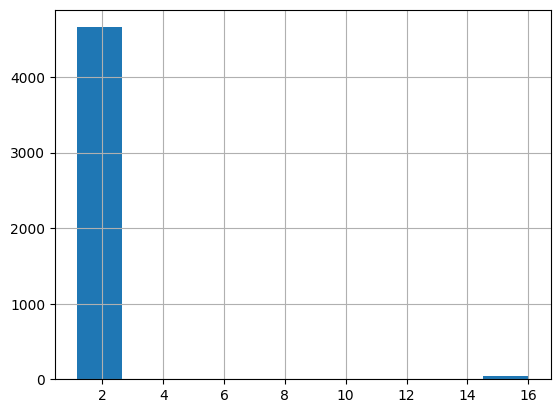

In [ ]:
# Durantion: Assuming the values are in minutes we have values up to 512 min which would be about 8hours of music which seens unlikely so we cloud replace the values above(+2stdev) the two standard deviation and below(-2stdev) it 
# if the median of the durantions
# Budget the highest budget of history was Star Wars: The Force Awakens with $447 million and the max value of budget is about $12 billion from a korean movie called the host. 
# Probably this entry is not right  or the currency is not normalized to dollars.
# Aspect ratio: the regular aspect_ratio for cinema is 2.39:1 (Widescreen cinema) and some 16.0 values were found they are a data errors probably being used instead of 16:9.
# movie_facebook_likes some values here are 0 what is unlike to happen, here we could use the average of likes for their imdb_score and replace the 0 value.
# cast_total_facebook_likes some values here are 0 what is unlike to happen, here we could use the average of likes for their imdb_score and replace the 0 value.




#760.505.847.0
#12.215.500.000.0
#data.sort_values(by='budget', ascending=False).head()
data['aspect_ratio'].hist()

In [24]:
# Evaluating ranges of likes columns
import re
like_columns = [item for item in data.describe().columns if re.search("like", item)]

validation_results_by_columns = []

for column in like_columns:
    expectation_value_between = gx.expectations.ExpectColumnValuesToBeBetween(column=column, min_value=0 , max_value=500000)
    results = batch.validate(expectation_value_between)
    validation_results_by_columns.append(
        {
            "Validation":results['success'],
            "Columns":results['expectation_config']['kwargs']['column'],
            "Element_count":results['result']['element_count'],
            "Unexpected_count":results['result']['unexpected_count'],
            "Unexpected_percent":results['result']['unexpected_percent'],
            "Partial_unexpected_list":results['result']['partial_unexpected_list'],
            "Partial_unexpected_index_list":results['result']['partial_unexpected_index_list']
            
        }
    )

df = pd.DataFrame(validation_results_by_columns)
report = df.loc[df['Validation']==False, : ]

Calculating Metrics: 100%|██████████| 10/10 [00:00<00:00, 277.74it/s]


In [25]:
report

,Validation,Columns,Element_count,Unexpected_count,Unexpected_percent,Partial_unexpected_list,Partial_unexpected_index_list
2,False,actor_1_facebook_likes,5043,1,0.019857,[640000.0],[1902]
3,False,cast_total_facebook_likes,5043,1,0.019829,[656730],[1902]


In [26]:
# Other columns that can not be negative
non_negative_columns = ['title_year', 'imdb_score', 'aspect_ratio']

validation_results_by_columns = []

for column in non_negative_columns:
    expectation_value_between = gx.expectations.ExpectColumnValuesToBeBetween(column=column, min_value=0 , max_value=500000)
    results = batch.validate(expectation_value_between)
    validation_results_by_columns.append(
        {
            "Validation":results['success'],
            "Columns":results['expectation_config']['kwargs']['column'],
            "Element_count":results['result']['element_count'],
            "Unexpected_count":results['result']['unexpected_count'],
            "Unexpected_percent":results['result']['unexpected_percent'],
            "Partial_unexpected_list":results['result']['partial_unexpected_list'],
            "Partial_unexpected_index_list":results['result']['partial_unexpected_index_list']
            
        }
    )

df = pd.DataFrame(validation_results_by_columns)
report = df.loc[df['Validation']==False, : ]

Calculating Metrics: 100%|██████████| 10/10 [00:00<00:00, 250.01it/s]


In [27]:
report

,Validation,Columns,Element_count,Unexpected_count,Unexpected_percent,Partial_unexpected_list,Partial_unexpected_index_list


# 4. Data Integrity and Duplicates

Plan:

Duplicated:

We already performed a general duplicate check during the data loading phase.
In this step, we aim to highlight less obvious duplicate records that may not be exact matches but represent the same entity (e.g., same movie with slight variations in title formatting or metadata).

Integrity:

We'll validate the relationship between the color and title_year columns to ensure consistency.
The goal is to detect anomalies such as modern films incorrectly labeled as black-and-white, or older films marked as color, where that would be historically unlikely.

### 4.1 Duplicated

During the test of uniqueness in section 2.2.2, we found some duplicated items. During further investigation, we found items that would be identical if not for a specific field.

Example indexes 6 and 3461 they are diferente just for the field num_voted_users. This kind of problem is hard to threat without business knowledge! What would be the right value 383056 or 383071.


In [28]:
#Item found in the section 2.2.2 during  
data.loc[data['plot_keywords']=='sandman|spider man|symbiote|venom|villain', :]

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,J.K. Simmons,Spider-Man 3,383056,46055,Kirsten Dunst,0.0,sandman|spider man|symbiote|venom|villain,http://www.imdb.com/title/tt0413300/?ref_=fn_t...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0
3461,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,J.K. Simmons,Spider-Man 3,383071,46055,Kirsten Dunst,0.0,sandman|spider man|symbiote|venom|villain,http://www.imdb.com/title/tt0413300/?ref_=fn_t...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0


In [29]:
# Report from section 2.2.2 - testing the uniqueness of movie_imdb_link
results_unique_2

{
  "success": false,
  "expectation_config": {
    "type": "expect_column_values_to_be_unique",
    "kwargs": {
      "batch_id": "pandas-pd dataframe asset",
      "column": "movie_imdb_link"
    },
    "meta": {}
  },
  "result": {
    "element_count": 5043,
    "unexpected_count": 241,
    "unexpected_percent": 4.7789014475510605,
    "partial_unexpected_list": [
      "http://www.imdb.com/title/tt0413300/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt0848228/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt0360717/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt1074638/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt1014759/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt1623205/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt1104001/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt1343092/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt0918940/?ref_=fn_tt_tt_1",
      "http://www.imdb.com/title/tt3040964/?ref_=fn_tt_tt_1",
      "htt

### 4.2 Integrity

After 1960s color films become widely adopted so i decided to adopt 1970 as a threshold year. Was found 137 movies erroneous labeled as Black and White and was found 93 movies erroneous labeled as Color.

In [30]:
#All movies labeled as Black and White. After 1960s color films become widely adopted.
wrong_bw = data.loc[(data['color']=='Black and White') & (data['title_year']>1970), ['color','movie_title','title_year']]
#len(wrong_bw['movie_title'])
wrong_bw.head()


,color,movie_title,title_year
111,Black and White,Pearl Harbor,2001.0
149,Black and White,Die Another Day,2002.0
257,Black and White,The Aviator,2004.0
272,Black and White,Ali,2001.0
286,Black and White,Casino Royale,2006.0


In [31]:
wrong_cl = data.loc[(data['color']=='Color') & (data['title_year']<=1970), ['color','movie_title','title_year']]
#len(wrong_cl['movie_title'])
wrong_cl.head()

,color,movie_title,title_year
1099,Color,"Yours, Mine and Ours",1968.0
1143,Color,Pinocchio,1940.0
1160,Color,Cleopatra,1963.0
1933,Color,Tora! Tora! Tora!,1970.0
2013,Color,Waterloo,1970.0


In [32]:
# Transformation to change the color labeling 

def color_or_black_and_white(data):

     data.loc[(data['color']=='Black and White') & (data['title_year']>1970), ['color']] = 'Color'
     data.loc[(data['color']=='Color') & (data['title_year']<=1970), ['color']] = 'Black and White'

     return data

data = color_or_black_and_white(data=data)

# 5. Data Enrichment

1. Understand the existing dataset:
Perform some EDA to understand the dataset we working with, some points of attention:

- Movie title

- Release year

- Director name

- IMDB score

- Actors

2. Identify relevant external sources that can enhance prediction or analysis. Examples:

- Box Office - https://github.com/lamlamngo/Box-Office-Mojo-API 
- IMDb API   - https://developer.imdb.com/documentation/api-documentation/?ref_=side_nav

3. Enrichment steps:

- Step 1: Normalize movie names and years to match across sources.

- Step 2: Use APIs or data scrapers to fetch external data.

- Step 3: Perform joins or merges (e.g.,movie_title", "title_year", "num_voted_users", "cast_total_facebook_likes").

- Step 4: Handle duplicates, missing values, and mismatches.

4. Practical Example

- Step 1: Filter all the rows with 'gross' equals to zero. We filled the missing values of gross with zeros and the groos column as the column with most missing values.
- Step 2: We could access the Box Office API and call it interactively by the name of the movie using the method get_movie_stats_by_name(). The return would be as below:

``` 
[{
                
'title': 'Black Panther (2018)',
 'overview': {
 'domestic': '$700,059,566',
 'international': '$646,853,595',
 'worldwide': '$1,346,913,161',
 'opening': '$202,003,951'
}, ... ]}
```
- Step 3: Acessing the value of 'worldwide' in section 'overview' we could enrich the information of the gross column.

In [94]:
data.loc[data['gross']==0, :]
#data.loc[data['movie_title']=='Black Panther (2018)', :]

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
84,Color,Roland Joffé,10.0,109.0,596.0,283.0,Alice Englert,622.0,0.0,Action|Adventure|Romance|Sci-Fi,Tamsin Egerton,The Lovers,2138,1982,Bipasha Basu,3.0,1770s|british india|great barrier reef|india|ring,http://www.imdb.com/title/tt1321869/?ref_=fn_t...,15.0,English,Belgium,R,0.0,2015.0,525.0,4.5,0.00,677
98,Color,Hideaki Anno,1.0,120.0,28.0,12.0,Shin'ya Tsukamoto,544.0,0.0,Action|Adventure|Drama|Horror|Sci-Fi,Mark Chinnery,Godzilla Resurgence,374,699,Atsuko Maeda,0.0,blood|godzilla|monster|sequel,http://www.imdb.com/title/tt4262980/?ref_=fn_t...,13.0,Japanese,Japan,0,0.0,2016.0,106.0,8.2,2.35,0
242,Color,Frédéric Forestier,33.0,116.0,0.0,141.0,Santiago Segura,936.0,0.0,Adventure|Comedy|Family|Fantasy,Alain Delon,Asterix at the Olympic Games,20567,1609,Vanessa Hessler,1.0,1st century b.c.|lightsaber|local blockbuster|...,http://www.imdb.com/title/tt0463872/?ref_=fn_t...,36.0,French,France,0,78000000.0,2008.0,276.0,5.1,2.35,291
422,Color,Bob Fosse,84.0,123.0,189.0,87.0,Ben Vereen,813.0,0.0,Comedy|Drama|Music|Musical,Roy Scheider,All That Jazz,19228,1476,Max Wright,0.0,dancer|editing|stand up comedian|surgery|vomiting,http://www.imdb.com/title/tt0078754/?ref_=fn_t...,146.0,English,USA,R,0.0,1979.0,388.0,7.8,1.85,0
430,Color,George A. Romero,127.0,130.0,0.0,602.0,Hal Holbrook,875.0,0.0,Comedy|Fantasy|Horror,Ted Danson,Creepshow,29932,2662,Adrienne Barbeau,0.0,anthology|child abuse|critically acclaimed|dea...,http://www.imdb.com/title/tt0083767/?ref_=fn_t...,211.0,English,USA,R,8000000.0,1982.0,826.0,6.9,1.85,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5018,Color,Alex Kendrick,5.0,120.0,589.0,4.0,Lisa Arnold,51.0,0.0,Drama,Shannen Fields,Flywheel,2986,108,Janet Lee Dapper,1.0,baby|car salesman|christian film|pregnancy|use...,http://www.imdb.com/title/tt0425027/?ref_=fn_t...,49.0,English,USA,0,20000.0,2003.0,49.0,6.9,1.85,725
5019,Color,Marcus Nispel,43.0,91.0,158.0,265.0,Brittany Curran,630.0,0.0,Horror|Mystery|Thriller,Ashley Tramonte,Exeter,3836,2679,Lindsay MacDonald,0.0,asylum|demon|party|secret|teenager,http://www.imdb.com/title/tt1945044/?ref_=fn_t...,33.0,English,USA,R,0.0,2015.0,512.0,4.6,1.85,0
5024,Color,Jason Trost,42.0,78.0,91.0,86.0,Jason Trost,407.0,0.0,Sci-Fi|Thriller,Sean Whalen,All Superheroes Must Die,1771,674,Nick Principe,0.0,arch villain|game of death|kidnapping|superhero,http://www.imdb.com/title/tt1836212/?ref_=fn_t...,35.0,English,USA,Unrated,20000.0,2011.0,91.0,4.0,2.35,835
5032,Color,Ash Baron-Cohen,10.0,98.0,3.0,152.0,Stanley B. Herman,789.0,0.0,Crime|Drama,Peter Greene,Bang,438,1186,James Noble,1.0,corruption|homeless|homeless man|motorcycle|ur...,http://www.imdb.com/title/tt0109266/?ref_=fn_t...,14.0,English,USA,0,0.0,1995.0,194.0,6.4,0.00,20


# 6. Data Transformation and Standardization

**Standardization:**

Standardization is the process of transforming data so that it has a mean of 0 and a standard deviation of 1. 
This is done by subtracting the mean of each feature and dividing by the standard deviation. It centers the data and scales it based on variability.

When to Use:

 - When features have different scales, and models are sensitive to the scale (e.g., SVM, logistic regression, k-NN, PCA).

 - When data is normally distributed, or you want to compare features in terms of standard deviation.

Impact:

 - Helps many ML algorithms converge faster.

 - Prevents features with larger scales from dominating distance-based models.

 - Important for gradient-based algorithms.



**Normalization:**

Normalization is the process of rescaling data to a fixed range, typically [0, 1]. 
It adjusts the values so that they all fall within a specific interval, preserving the shape of the distribution but changing the scale.

When to Use:

 - When using models that assume bounded input values, like neural networks or clustering.

 - When you want to preserve the original distribution but bring values into a specific scale.

Impact:

 - Can significantly speed up convergence in neural networks.

 - Helps avoid numerical instability when feature values vary widely.


The columns that would need transformations, such as standardization and normalization, are the numeric ones, as shown below. 
Since we have a huge disparity on scale of the columns for example between gross and imdb_score we would need to apply a normalization in order to the model don't associate a very big weight in features like groos and budget.
About the standartization if the select model expects a normal curve in it's input i would apply the transfomation however if it's not the case i would prefer not aplly it justt because real data usually dont follow a normal curve.

In [33]:
# Filtering the numeric variables
data.select_dtypes(exclude='object')

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,723.0,178.0,0.0,855.0,1000.0,760505847.0,886204,4834,0.0,3054.0,237000000.0,2009.0,936.0,7.9,1.78,33000
1,302.0,169.0,563.0,1000.0,40000.0,309404152.0,471220,48350,0.0,1238.0,300000000.0,2007.0,5000.0,7.1,2.35,0
2,602.0,148.0,0.0,161.0,11000.0,200074175.0,275868,11700,1.0,994.0,245000000.0,2015.0,393.0,6.8,2.35,85000
3,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,1144337,106759,0.0,2701.0,250000000.0,2012.0,23000.0,8.5,2.35,164000
5,462.0,132.0,475.0,530.0,640.0,73058679.0,212204,1873,1.0,738.0,263700000.0,2012.0,632.0,6.6,2.35,24000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5034,35.0,80.0,0.0,0.0,0.0,70071.0,589,0,0.0,35.0,7000.0,2005.0,0.0,6.3,0.00,74
5035,56.0,81.0,0.0,6.0,121.0,2040920.0,52055,147,0.0,130.0,7000.0,1992.0,20.0,6.9,1.37,0
5037,14.0,95.0,0.0,133.0,296.0,4584.0,1338,690,1.0,14.0,9000.0,2011.0,205.0,6.4,0.00,413
5038,1.0,87.0,2.0,318.0,637.0,0.0,629,2283,2.0,6.0,0.0,2013.0,470.0,7.7,0.00,84


# 7. Pipeline Design

![pipeline](image/pynne_test_pipeline.png)

**Pipeline:**

To ensure robust, continuous handling of datasets similar to the one provided, I designed a modular data pipeline consisting of six key stages: Data Ingestion, Data Cleaning, Quality Checks, Data Validation, Reporting Dashboards, and Write Operation. Each stage is purposefully separated for maintainability, scalability, and data quality assurance.

Orchestration pipeline:
 - Purpose: Define, schedule, and monitor workflows as Directed Acyclic Graphs (DAGs). With airflow, we have clear task dependencies, retry mechanisms, and alerting, task-level monitoring and logging, scalable and modular design.

 - Design Choice: Airflow was the choice here as the core orchestration tool due to its flexibility, reliability, and rich ecosystem


Data Ingestion:
 - Purpose: Capture raw data from various sources (e.g., APIs, databases, CSV files, streaming platforms).

 - Design Choice: I opted for Apache Kafka as a streaming ingestion mechanism or python code encapsulated in Airflow for batch ingestion mechanism additionally cloud-native services coul be used (e.g., Composer, MWAA, Azure Data Factory).

 - Consideration: The ingestion layer supports schema evolution and tracks data lineage for auditability.

Data Cleaning:
 - Purpose: Normalize and clean raw data to make it consistent and usable.

 - Design Choice: Applied transformation logic using tools like Spark, Pandas, and Polars ... to handle missing values and format inconsistencies.

 - Consideration: Cleaning rules are modular and version-controlled, allowing quick updates as data characteristics evolve.

Quality Checks:
 - Purpose: Automatically detect anomalies or issues in the data (e.g., nulls, duplicates, threshold violations) it also include checks like range constraints, uniqueness, and referential integrity with reference tables.

 - Design Choice: Used data quality frameworks such as Great Expectations or custom logic embedded in ETL scripts.

 - Consideration: Alerts are triggered when data fails specific quality thresholds, and logs/reports are maintained for debugging.

Data Validation:
 - Purpose: Ensure data conforms to expected schemas, types.

 - Design Choice: Schema validation is performed using Pydantinc because of the simplicity of use.

 - Consideration: The schema validation with the PyDantic model gives you the ability to parse it and ensure that we are using the right schema.

Reporting Dashboards:
 - Purpose: Provide visibility into the pipeline’s health and data status for stakeholders.

 - Design Choice: Implemented real-time dashboards using tools like Grafana, Tableau, or Power BI connected to metadata and monitoring stores.

 - Consideration: Dashboards display metrics like row counts, failure rates, pipeline latency, data freshness and others quality metrics.

Write Operation:
 - Purpose: Store processed data into target destinations in a different layer, such as interim, since we are getting data from raw in the first step. (e.g., data lake, warehouse, or downstream APIs).

 - Design Choice: Data is partitioned and written using optimized formats (like Parquet or ORC) into destinations such as gcs, BigQuery, or S3 and Redshift.

 - Consideration: Versioning and ACID-compliance are considered, especially for analytical use cases.

# 8. Bonus Challenge Question - Actor Collaboration and Performance Analysis

Definition:

An adjacency matrix is a square matrix used to represent a graph, where each row and column represents a vertex (node) in the graph.


Demonstrate and explain how you would create an adjacency matrix based on co-acting performance, measured by IMDb scores:

- First step:  Filter the needed columns 'actor_1_name', 'actor_2_name', 'actor_3_name', 'imdb_score'.

- Second step: Ravel the values of the 'actor_1_name', 'actor_2_name', 'actor_3_name', and get the unique values of them.
                  Flatten the values of the column in 1-dimensional is necessary in order for we to have one array with the unique values of the actors.

- Third step: Map the actor's name to indexes.

- Fourth step: Initialize zeros imdb_matrix and likes_matrix.

- Fifth step: Build an adjacency matrix where each cell (i, j) represents the number of co-acted movies between actor_i and actor_j, weighted by IMDb score
                 and a matrix with avg_number of likes between the actor_i and actor_j.

- Sixth step: return the imdb_matrix, like_matrix.
                 

Describe how you'd visualize the top-performing actor pairs and run a correlation analysis between actor-pair likes and IMDb scores:

- To visualize we could identify top actor pairs based on IMDb score and highlight those points in the correlation scatter plot and also annotate the top points with actor names.

- For the correlation analysis i would run  a pearson correlation test between the like_scores, imdb_scores and log the result.


Outline your method for identifying the largest co-acting group, considering direct or indirect connections between actors:

- Here i choose to use NetworkX, a Python graph library, to detect connected components, which are subgraphs where every actor is reachable from any other actor (direct or indirect connection).

- The largest co-acting group is just the biggest cluster of actors who are connected either directly or indirectly

In [ ]:
def build_coacting_adjacency_matrix(df: pd.DataFrame):
     

    """
        Builds adjacency matrices representing co-acting relationships between actors 
        based on IMDB scores and Facebook likes.

    Args:
        df (pd.DataFrame): A DataFrame with the following columns:
            - 'actor_1_name', 'actor_2_name', 'actor_3_name'
            - 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes'
            - 'imdb_score'

    Returns:
        - imdb_matrix (np.ndarray): A symmetric matrix with shape (n, n), 
              where n is the number of unique actors, and each [i, j] entry is 
              the sum of IMDB scores for movies in which actor i and j co-acted.
        - like_matrix (np.ndarray): A symmetric matrix with shape (n, n), 
              where each [i, j] entry is the sum of average Facebook likes for 
              co-acting pairs.
        - index_actor (dict): A mapping from matrix indices to actor names.
    """
     
    df = df[['actor_1_name', 'actor_2_name', 'actor_3_name',
             'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes',
             'imdb_score']].dropna()

    actors_set = pd.unique(df[['actor_1_name', 'actor_2_name', 'actor_3_name']].values.ravel('K'))
    actor_index = {actor: idx for idx, actor in enumerate(actors_set)}
    index_actor = {idx: actor for actor, idx in actor_index.items()}

    n = len(actors_set)
    imdb_matrix = np.zeros((n, n))
    like_matrix = np.zeros((n, n))

    for _, row in df.iterrows():
        actors = [row['actor_1_name'], row['actor_2_name'], row['actor_3_name']]
        likes = [row['actor_1_facebook_likes'], row['actor_2_facebook_likes'], row['actor_3_facebook_likes']]
        imdb = row['imdb_score']

        for (i, a1), (j, a2) in combinations(enumerate(actors), 2):
            idx1, idx2 = actor_index[a1], actor_index[a2]
            imdb_matrix[idx1][idx2] += imdb
            imdb_matrix[idx2][idx1] += imdb
            avg_likes = (likes[i] + likes[j]) / 2
            like_matrix[idx1][idx2] += avg_likes
            like_matrix[idx2][idx1] += avg_likes

    return imdb_matrix, like_matrix, index_actor

def correlation_likes_vs_imdb(imdb_matrix:np.array, like_matrix:np.array, index_actor:dict, top_n:int=10):


    """
    Computes and visualizes the Pearson correlation between co-acting IMDb scores 
    and average Facebook likes for actor pairs.

    Args:
        imdb_matrix (np.ndarray): Adjacency matrix of IMDb score sums for actor pairs.
        like_matrix (np.ndarray): Adjacency matrix of average Facebook likes for actor pairs.
        index_actor (dict): Mapping from matrix indices to actor names.
        top_n (int, optional): Number of top actor pairs to highlight. Default is 10.

    Returns:
        None. Displays a scatter plot and prints the Pearson correlation coefficient.
    """
    

    index_actor=list(index_actor.keys())
    imdb_scores = []
    like_scores = []
    pairs = []

    n = imdb_matrix.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            if imdb_matrix[i][j] > 0:
                imdb_scores.append(imdb_matrix[i][j])
                like_scores.append(like_matrix[i][j])
                pairs.append((index_actor[i], index_actor[j]))

    # Compute correlation
    corr, _ = pearsonr(like_scores, imdb_scores)
    print(f"Pearson Correlation: {corr:.2f}")

    # Prepare DataFrame for plotting
    plot_df = pd.DataFrame({
        'IMDb Score Sum': imdb_scores,
        'Facebook Likes': like_scores,
        'Actor Pair': [f"{a1} & {a2}" for a1, a2 in pairs]
    })

    # Get top N pairs
    top_pairs = plot_df.sort_values(by='IMDb Score Sum', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=plot_df, x='Facebook Likes', y='IMDb Score Sum', alpha=0.4)
    sns.scatterplot(data=top_pairs, x='Facebook Likes', y='IMDb Score Sum', color='red', label='Top Pairs')

    # Annotate top pairs
    for _, row in top_pairs.iterrows():
        plt.text(row['Facebook Likes'], row['IMDb Score Sum'], row['Actor Pair'], fontsize=8)

    plt.title("Correlation: Likes vs IMDb Score")
    plt.xlabel("Mean Facebook Likes")
    plt.ylabel("Total IMDb Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def find_largest_coacting_group(imdb_matrix:np.array, index_actor:dict, label:bool=False):

    """
        Identifies and visualizes the largest connected group of co-acting actors based on IMDb scores.

        Args:
            imdb_matrix (np.ndarray): Adjacency matrix of IMDb score sums for actor pairs.
            index_actor (dict): Mapping from matrix indices to actor names.
            label (bool, optional): Whether to display actor names in the visualization. Default is False.

        Returns:
            set: A set of actor names in the largest co-acting group.
    """

    
    G = nx.Graph()
    n = imdb_matrix.shape[0]
    actor_list = list(index_actor.keys())

    for i in range(n):
        for j in range(i+1, n):
            if imdb_matrix[i][j] > 0:
                G.add_edge(actor_list[i], actor_list[j], weight=imdb_matrix[i][j])

    largest_cc = max(nx.connected_components(G), key=len)
    print(f"Largest Co-acting Group Size: {len(largest_cc)}")
    
    # Visualize
    subgraph = G.subgraph(largest_cc)
    plt.figure(figsize=(15, 12))
    nx.draw(subgraph, with_labels=label, node_size=500, font_size=8)
    plt.title("Largest Co-Acting Group")
    plt.show()

    return largest_cc

In [53]:
imdb_matrix, like_matrix, index_actor, _ = build_coacting_adjacency_matrix(df=data)

Pearson Correlation: 0.31


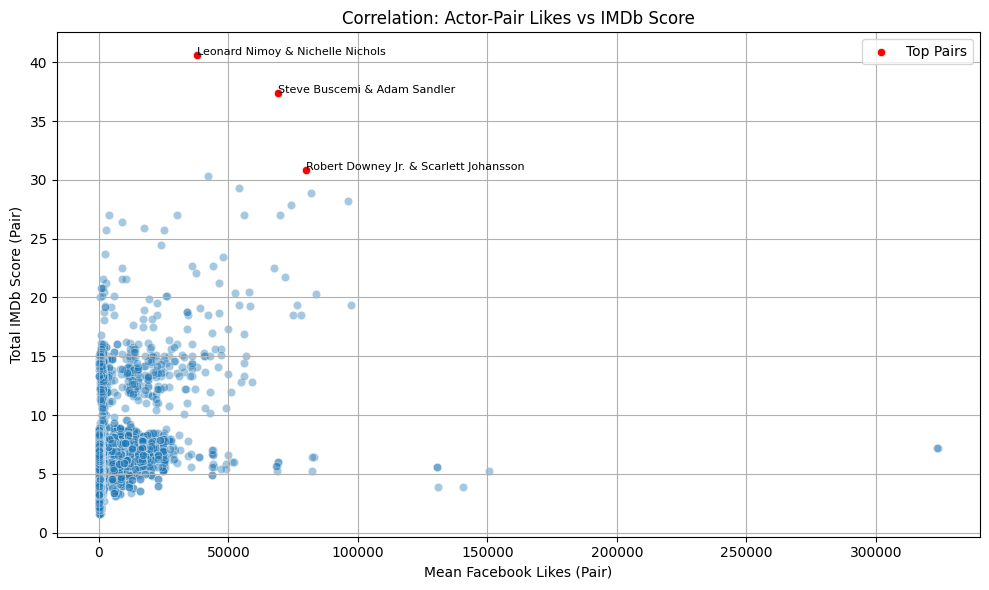

In [ ]:
imdb_scores = correlation_likes_vs_imdb(imdb_matrix=imdb_matrix, like_matrix=like_matrix, index_actor=index_actor, top_n=3)

Largest Co-acting Group Size: 4400


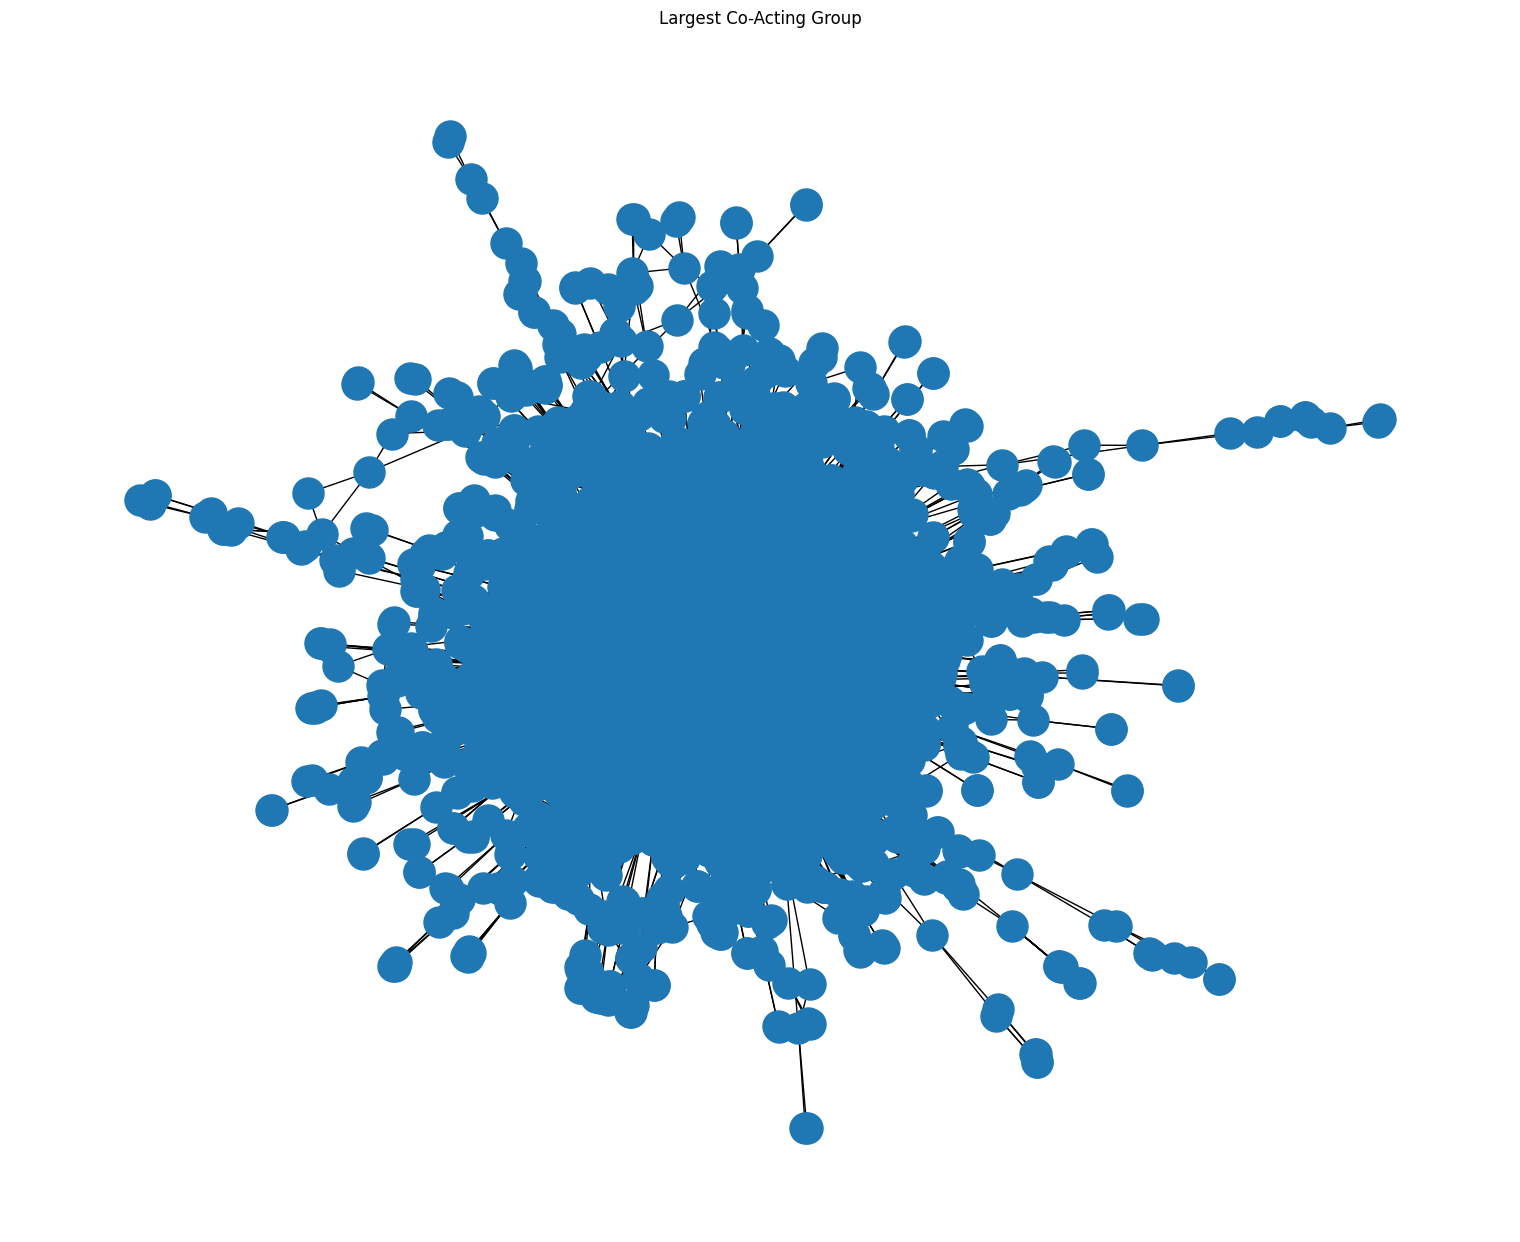

In [88]:
largest_cc = find_largest_coacting_group(imdb_matrix=imdb_matrix, index_actor=index_actor, label=False)